# Reference:
[https://github.com/JustinBurg/TensorFlow_TimeSeries_RNN_MapR/blob/master/RNN_Timeseries_Demo.ipynb](https://github.com/JustinBurg/TensorFlow_TimeSeries_RNN_MapR/blob/master/RNN_Timeseries_Demo.ipynb)

In [4]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Pull test data from OpenTSDB 

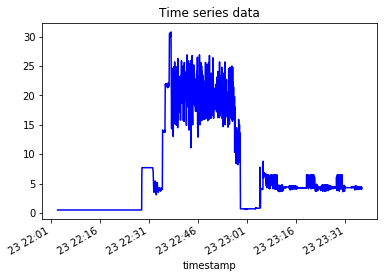

timestamp
2018-04-23 22:03:07    0.5
2018-04-23 22:03:10    0.5
2018-04-23 22:03:13    0.5
2018-04-23 22:03:16    0.5
2018-04-23 22:03:19    0.5
2018-04-23 22:03:22    0.5
2018-04-23 22:03:25    0.5
2018-04-23 22:03:28    0.5
2018-04-23 22:03:31    0.5
2018-04-23 22:03:34    0.5
dtype: float64

In [6]:
import base64
import requests
import yaml
url="http://172.31.47.222:4242/api/query?start=24h-ago&m=avg:Panel2Power"
headers = {'content-type': 'application/vnd.kafka.v1+json'}
r = requests.get(url, headers=headers)
d = (yaml.safe_load(r.text)[0]['dps'])
df3 = pd.DataFrame(list(d.items()))
df3.columns = ['timestamp', 'value']
df3['timestamp']=pd.to_datetime(df3['timestamp'], unit='s')
df3 = df3.sort_values(by=['timestamp'])
ts = pd.Series(df3['value'].values, index=df3['timestamp'])
ts.plot(c='b', title="Time series data")
plt.show()
ts.head(10)

# Segment the OpenTSDB data into windows
We'll train the RNN model based on a narrow segment of the data recorded in opentsdb.

In [7]:
TS = np.array(ts[0:801])
num_periods = 20
f_horizon = 1

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (y_batches.shape)

40
(40, 20, 1)
(40, 20, 1)


In [8]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY
X_test, Y_test = test_data(TS,f_horizon,num_periods)
print (X_test.shape)

(1, 20, 1)


In [9]:
import tensorflow as tf
import os
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


# Build the RNN model in Tensorflow

In [10]:
tf.reset_default_graph()
# num_periods = 20
inputs = 1
hidden = 100
output = 1

x = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)
learning_rate = 0.001
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [11]:
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={x: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={x: x_batches, y: y_batches})
            print (ep, "\tMSE:", mse)
            
    y_pred = sess.run(outputs, feed_dict={x: X_test})

0 	MSE: 85429.19
100 	MSE: 5241.674
200 	MSE: 3305.5452
300 	MSE: 2155.166
400 	MSE: 1266.0721
500 	MSE: 835.5771
600 	MSE: 666.8363
700 	MSE: 579.55963
800 	MSE: 532.08136
900 	MSE: 488.70654


# Compare forecasts with ground truth

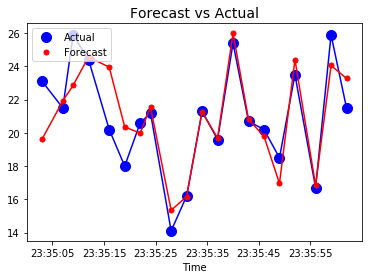

In [12]:
plt.title("Forecast vs Actual", fontsize = 14)
timestamps = df3['timestamp'][-len(pd.Series(np.ravel(Y_test))):].values
plt.plot(timestamps, pd.Series(np.ravel(Y_test)), "b-", markersize = 10)
plt.plot(timestamps, pd.Series(np.ravel(Y_test)), "bo", markersize = 10, label="Actual")
plt.plot(timestamps, pd.Series(np.ravel(y_pred)), "r-", markersize = 10)
plt.plot(timestamps, pd.Series(np.ravel(y_pred)), "r.", markersize = 10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()